
## STOCHASTIC MODELING
MODULE 4 | LESSON 2


---

|  |  |
|:---|:---|
|**Reading Time** |  60 minutes |
|**Prior Knowledge** |Linear Algebra, Maximum likelihood estimator, Monte Carlo  |
|**Keywords** |Markov Process, Markov chains, Transition Matrix


---

*In this notebook, we continue exploring Markov processes. First, we apply the concept of a transition matrix to bond valuation. Second, we introduce the gambler's ruin problem. Finally, we show how to discretize Gaussian linear continuous process, AR(1), using Markov chains.*

# **BOND VALUATION**

## **1. Bond Valuation with Ratings Transition Matrix**

Consider a corporation that has an outstanding bond that has been rated as BB and matures in 5 years, with a 4% coupon. The current forward interest rates for years 1 to 4 appear in the table below. With this information and the transition matrix that we introduced in Lesson 1, we can compute a **one-year-ahead estimate** of the bond value.

* **Step 1**. Compute the present value of the bond + coupon in one year's time using the forward rates.

* **Step 2**. Compute the expected value of the bond and the distribution of value changes using the transition matrix.

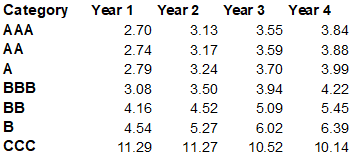

In the above matrix, we have the estimation of the term structure of interest rates for each rating class. For instance, the 2.7% for AAA in year 1, means that the expected interest rate from year 1 to year 2 is 2.7% for AAA bonds.Thus, we can compute the bond value, in one year, for each possible future state. 

In [2]:
# LIBRARIES WE USE IN THE NOTEBOOK
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, seed
from scipy.stats import norm

In [21]:
RATINGS = dict(
    [
        ("AAA", 0),
        ("AA", 1),
        ("A", 2),
        ("BBB", 3),
        ("BB", 4),
        ("B", 5),
        ("CCC", 6),
        ("D", 7),
    ]
)
CURR_RATING = "CCC"
VAR_PR = 99.0
COUPON = 4

P0 = np.array(
    [
        [87.06, 9.06, 0.53, 0.05, 0.11, 0.03, 0.05, 0.0, 3.11],
        [0.48, 87.23, 7.77, 0.47, 0.05, 0.06, 0.02, 0.02, 3.89],
        [0.03, 1.6, 88.58, 5.0, 0.26, 0.11, 0.02, 0.05, 4.35],
        [0, 0.09, 3.25, 86.49, 3.56, 0.43, 0.1, 0.16, 5.92],
        [0.01, 0.03, 0.11, 4.55, 77.82, 6.8, 0.55, 0.63, 9.51],
        [0.0, 0.02, 0.07, 0.15, 4.54, 74.6, 4.96, 3.34, 12.33],
        [0.0, 0.0, 0.1, 0.17, 0.55, 12.47, 43.11, 28.3, 15.31],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0],
    ]
)


F = np.array(
    [
        [2.70, 3.13, 3.55, 3.84],
        [2.74, 3.17, 3.59, 3.88],
        [2.79, 3.24, 3.70, 3.99],
        [3.08, 3.50, 3.94, 4.22],
        [4.16, 4.52, 5.09, 5.45],
        [4.54, 5.27, 6.02, 6.39],
        [11.29, 11.27, 10.52, 10.14],
    ]
)
print("Forward rates matrix\n", F)

N_RATINGS = P0.shape[0]
print("Number of Ratings =", N_RATINGS)
N_YEARS = F.shape[1]
print("Number of years in the forward rates matrix =", N_YEARS)
MAT = 5
print("Bond maturity: ", MAT)

Forward rates matrix
 [[ 2.7   3.13  3.55  3.84]
 [ 2.74  3.17  3.59  3.88]
 [ 2.79  3.24  3.7   3.99]
 [ 3.08  3.5   3.94  4.22]
 [ 4.16  4.52  5.09  5.45]
 [ 4.54  5.27  6.02  6.39]
 [11.29 11.27 10.52 10.14]]
Number of Ratings = 8
Number of years in the forward rates matrix = 4
Bond maturity:  5


The first step (see code below) is to normalize the transition matrix ignoring the "NR" type. In other words, we delete "NR" types and force that the sum of probs are equal to one. <span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [22]:
# Normalize transition matrix, ignoring NR type
P = P0[:, 0 : P0.shape[1] - 1]  # noQA E203
P = (P.T / np.sum(P, axis=1)).T

print("Transition Matrix (normalized):\n", P)

Transition Matrix (normalized):
 [[8.98544741e-01 9.35081020e-02 5.47012076e-03 5.16049128e-04
  1.13530808e-03 3.09629477e-04 5.16049128e-04 0.00000000e+00]
 [4.99479709e-03 9.07700312e-01 8.08532778e-02 4.89073881e-03
  5.20291363e-04 6.24349636e-04 2.08116545e-04 2.08116545e-04]
 [3.13643492e-04 1.67276529e-02 9.26084684e-01 5.22739153e-02
  2.71824360e-03 1.15002614e-03 2.09095661e-04 5.22739153e-04]
 [0.00000000e+00 9.56632653e-04 3.45450680e-02 9.19323980e-01
  3.78401361e-02 4.57057823e-03 1.06292517e-03 1.70068027e-03]
 [1.10497238e-04 3.31491713e-04 1.21546961e-03 5.02762431e-02
  8.59889503e-01 7.51381215e-02 6.07734807e-03 6.96132597e-03]
 [0.00000000e+00 2.28102190e-04 7.98357664e-04 1.71076642e-03
  5.17791971e-02 8.50821168e-01 5.65693431e-02 3.80930657e-02]
 [0.00000000e+00 0.00000000e+00 1.18063754e-03 2.00708383e-03
  6.49350649e-03 1.47225502e-01 5.08972845e-01 3.34120425e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+0

Notice that we assume a recovery rate of 62%. 

In [23]:
D_RECOVERY = 62.7

bond_values = np.zeros(N_RATINGS)
bond_values[N_RATINGS - 1] = D_RECOVERY
for r in range(0, N_RATINGS - 1):
    bond_values[r] = COUPON
    for t in range(0, N_YEARS):
        bond_values[r] = bond_values[r] + (COUPON + 100 * (N_YEARS - 1 == t)) / (
            1 + (F[r, t] / 100.0)
        ) ** (t + 1)

print("Bond values:\n ", bond_values)
pw_values = np.multiply(bond_values, P[RATINGS[CURR_RATING], :])
bond_val = np.sum(pw_values)
print("Bond value (one-year ahead): ", bond_val)

Bond values:
  [104.70709188 104.56079519 104.1650763  103.32804065  99.05812232
  95.96885329  84.4609282   62.7       ]
Bond value (one-year ahead):  79.04033597514916


Thus, we are able to compute the expected value of the bond one year ahead using the transition matrix. 

## **2. Two Absorbing States: Gambler's Ruin**

Now, consider the following situation. A gambler bets on the outcome of a sequence of independent fair coin tosses. With each heads, the gambler gains one dollar. With each tails, the gambler loses one dollar. The gambler stops betting after reaching a fortune of $\overline{S}$ dollars or after emptying their pockets.

*   What are the probabilities of each stopping outcome?
*   How long will it take for the gambler, in expectation, to arrive at one of the stopping outcomes?

To answer these questions, we can model this setting as a Markov chain on the state space $\mathcal{S}\in\{0,1,...,\overline{s}\}$. The gambler starts with initial money $k\in\mathcal{S}$, and $s_t$ represents the money in the gambler's pocket at time $t$. Thus, we have that, for $0\lt s_t \lt \overline{s}$:

*   $\mathbb{P}(s_{t+1}=s_t+1|s_{t})=0.5$
*   $\mathbb{P}(s_{t+1}=s_t-1|s_{t})=0.5$

States 0 and $\overline{s}$ are absorbing states because any sequence of draws from the Markov chain stops after reaching any of those situations. Alternatively, we can think that $\mathbb{P}(s_{t+1}=s_t|s_{t}=\overline{s})=\mathbb{P}(s_{t+1}=s_t|s_{t}=0)=1$. We can then represent the $(\overline{s}+1)\times(\overline{s}+1)$ transition matrix as:
$$
\begin{align}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 &\cdots & 0 \\
0.5 & 0 & 0.5 & 0 & 0 &\cdots & 0 \\
0 & 0.5 & 0 & 0.5 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots& \cdots & \vdots \\
0 & 0 & 0 & 0.5 & 0 & 0.5 & 0 \\
0 & 0 & 0 & 0 & 0.5 & 0 & 0.5 \\
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\end{align} 
$$
Before solving this with math, let's see some Monte Carlo simulation results (in this example, the gambler stops betting after reaching a fortune of 5 USD and starts with 1 USD):

In [ ]:
# seed random number generator
seed(12345)

TARGET_PURSE = 10
INIT_PURSE = 4

N_STATES = TARGET_PURSE + 1

S = np.zeros((N_STATES, 1))
P = np.zeros((N_STATES, N_STATES))

P[0, 0] = 1.0
P[N_STATES - 1, N_STATES - 1] = 1.0

for ii in range(1, N_STATES - 1):
    for jj in range(0, N_STATES):
        if jj == ii - 1 or jj == ii + 1:
            P[ii, jj] = 0.5

print("Transition matrix:\n", P)

Transition matrix:
 [[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


In [12]:
seed(42)

target = 5
initial = 1
n_states = target + 1

S = np.zeros((n_states, 1))
P = np.zeros((n_states, n_states))

P[0, 0] = 1.0
P[n_states - 1, n_states - 1] = 1.0

for ii in range(1, n_states - 1):
    for jj in range(0, n_states):
        if jj == ii - 1 or jj == ii + 1:
            P[ii, jj] = 0.5

print(f"Transition matrix:\n{P}")

Transition matrix:
[[1.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  1. ]]


In [17]:
# seed random number generator
seed(12345)

TARGET_PURSE = 20
INIT_PURSE = 5

N_STATES = TARGET_PURSE + 1

S = np.zeros((N_STATES, 1))
P = np.zeros((N_STATES, N_STATES))

P[0, 0] = 1.0
P[N_STATES - 1, N_STATES - 1] = 1.0

for ii in range(1, N_STATES - 1):
    for jj in range(0, N_STATES):
        if jj == ii - 1 or jj == ii + 1:
            P[ii, jj] = 0.5

print("Transition matrix:\n", P)

N_HISTORIES = 5000  # number of histories or simulations
LEN_HIST = 1000  # Length of each simulation
histories = np.zeros((N_HISTORIES, LEN_HIST))
histories[:, 0] = INIT_PURSE * np.ones(N_HISTORIES)
randarray = rand(N_HISTORIES, LEN_HIST)

for i in range(0, N_HISTORIES):
    for j in range(1, LEN_HIST):
        histories[i, j] = (
            histories[i, j - 1] + (randarray[i, j] >= 0.5) - (randarray[i, j] < 0.5)
        )
        if histories[i, j] == TARGET_PURSE or histories[i, j] < 1:
            histories[i, j + 1 : LEN_HIST + 1] = histories[i, j]  # noQA E203
            break

target_num = np.sum(np.max(histories, axis=1) == TARGET_PURSE)

end_gamble = np.zeros(N_HISTORIES)
end_gamble_sum = 0

for i in range(0, N_HISTORIES):
    if np.max(histories[i, :]) == TARGET_PURSE:
        where_gamble_ends_T = np.where((histories[i, :] == TARGET_PURSE))
        end_gamble[i] = where_gamble_ends_T[0][0]
        end_gamble_sum += 1
    elif np.min(histories[i, :]) < 1:
        where_gamble_ends_0 = np.where((histories[i, :] < 1))
        end_gamble[i] = where_gamble_ends_0[0][0]
        end_gamble_sum += 1
    else:
        end_gamble[i] = 0.0

broke_num = np.sum(np.min(histories, axis=1) < 1)

print(
    "Probability of getting the target:",
    target_num / N_HISTORIES,
    "\nProbability of losing all the money:",
    broke_num / N_HISTORIES,
)
print(
    "Expected time until reaching a stopping result:",
    np.sum(end_gamble) / end_gamble_sum,
    "\nTotal number of simulations:",
    end_gamble_sum,
)

Transition matrix:
 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.
  0.  0.  0. ]
 [0.  0.  0.

Using Monte Carlo, we've seen that the probability of getting the target, that is to get $\overline{s}=5$, is equal to 20%. On the other hand, the probability of getting zero (losing all the money) is equal to 80%. Finally, we also know that the expected time until reaching either zero or $\overline{s}=5$ is equal to 4. In the next section, we show that these results are already known using simple math.

## **2.1 Gambler's Ruin (Proof)**

Let $P_k$ denote the probability that the gambler gets the amount $\overline{s}$ conditional on the gambler having an amount $k$ of money in their pockets. Then, by the Markov property, we know that $P_k = 0.5P_{k+1}+0.5P_{k-1}$, which we can rewrite as $P_{k+1} - P_k = P_{k} - P_{k-1}$, for $k\in\{1,\overline{s}-1\}$. Notice that $P_0=0$ and $P_{\overline{s}}=1$. Thus, we have that

$P_2 - P_1 = P_1\\ 
P_3 - P_2 = P_2 - P_1 = P_1 \\
P_{k+1} - P_k = ... = P_1$

from where we obtain that $P_{k+1}=P_1(1+k)$. Since $P_{\overline{s}}=1$, we get that $P_1=\frac{1}{\overline{s}}$, and that $P_k=\frac{k}{\overline{s}}$.

Let's now denote by $T_k=E(t|s_t=\overline{s}\ \text{or}\ 0,s_0=k)$ the expected time until reaching either $\overline{s}$ or 0 when the gambler starts with an amount of money $k$. Then, notice that $T_k=0.5(1 + T_{k+1}) + 0.5(1 + T_{k-1})$ for $k\in\{1,\overline{s}-1\}$. We can rewrite the expression for $T_k$ as

$0.5(T_{k+1}-T_{k}) + 1 = 0.5(T_{k}-T_{k-1}) \\
 T_{k+1}-T_{k} = T_{k}-T_{k-1} - 2$

Verify that the previous expression boils down to the following sequence, noting that $T_0=0$:

$T_{k+1} = (k+1)T_1 - 2\sum_{i=1}^k i = (k+1)(T_1 - k)$

Because $T_{\overline{s}}=0$, we can solve for $T_1$:

$\overline{s}(T_1 - \overline{s} - 1)=0 \rightarrow T_1 = \overline{s} - 1$

Thus, for $k\in\{1,\overline{s}-1\}$ we finally obtain:

$T_{k} = k(\overline{s}-k)$.

Applying the above results to the simulation case study, we conclude that:

$P_k=\frac{k}{\overline{s}} = \frac{1}{5} = 0.2$

and,

$T_{k} = k(\overline{s}-k) = 1\times(5-1) = 4$

These results have also been obtained using Monte Carlo in the previous section.

## **3. Markov-Chain Representation of a First-Order Autoregressive Process**

Sometimes, we deal with situations where our random variable of interest follows a continuous autoregressive process, i.e., a continuous Markov process. For simulation or optimization purposes, it is useful to follow a discretization method that preserves the main properties of the continuous process. The discretization involves constructing the Markov-chain that is "equivalent" to the autoregressive random variable. Let's cover two methods to achieve such discretization.

Consider a continuous random variable $z_t$ that follows a first-order autoregressive process (AR(1)):
$$
\begin{align}
z_t = \rho z_{t-1} + \varepsilon_t
\end{align}
$$
where $|\rho|\lt 1$, and $\varepsilon_t$ is white noise with variance $\sigma_{\varepsilon}^2$. The process is covariance-stationary with mean zero and variance $\sigma_{\varepsilon}^2/(1-\rho^2)$. If, in addition, $\varepsilon_t$ is normally distributed in each period, then $z_t$ is also normally distributed.

In all methods below, we are going to construct a grid of $N$ potential realizations of $z_t$, $\mathcal{Z}=\{z_1,...,z_N\}$, with an associated transition matrix P.

**Tauchen Method**

We set the upper and lower bounds of the Markov chain as:
$$
\begin{align}
z_1 = -\lambda \\
z_N = \lambda
\end{align}
$$
where $\lambda$ is $m$ times the unconditional standard deviation of the autoregressive process, $\sigma_\varepsilon/\sqrt{1-\rho^2}$. Then, construct the remaining grid points using an equally distributed space:
$$
\begin{align}
z_i = z_1 + \frac{z_N-z_1}{N-1}(i-1)\ \text{for}\ i=1,...,N \\
\end{align} 
$$
Let $m_i=\frac{z_{i+1}+z_i}{2}$ denote the mid-point between grid points $i$ and $i+1$. The transition probabilities $p_{ij}$ are given by:
$$
\begin{align}
& p_{ij} = \Phi\left(\frac{m_j-\rho z_i}{\sigma_\varepsilon}\right) - \Phi\left(\frac{m_{j-1}-\rho z_i}{\sigma_\varepsilon}\right)\ \text{for}\ j=2,...,N-1 \\
& p_{i1} = \Phi\left(\frac{m_1-\rho z_i}{\sigma_\varepsilon}\right)\\
& p_{iN} = 1-\Phi\left(\frac{m_{N-1}-\rho z_i}{\sigma_\varepsilon}\right)\\
\end{align}
$$
We can calibrate $\lambda$ by matching the actual unconditional variance of the autoregressive process. That is, we solve $\sum_i^N \pi_i z_i(\lambda)^2 = \sigma_{\varepsilon}^2/(1-\rho^2)$, where $\pi_i$ is the stationary distribution of the discretized Markov process.

**Rouwenhorst Method**

The Rouwenhorst discretization method begins with an equally spaced grid $\mathcal{Z}=\{z_1,...,z_N\}$ where $z_1=-z_N$. Then, choosing $p$ and $q$, we build the following matrix $P_2$:
$$
\begin{align}
P_2 = \begin{bmatrix}
p & 1-p \\
1-q & q
\end{bmatrix}
\end{align}
$$
then, for each $k=3,...,N$:
$$
\begin{align}
P_k = p \begin{bmatrix}
P_{k-1} & \mathbf{0} \\
\mathbf{0}' & 0
\end{bmatrix}
+ (1-p) \begin{bmatrix}
 \mathbf{0} & P_{k-1} \\
 0 & \mathbf{0}'
\end{bmatrix}
+ (1-q) \begin{bmatrix}
 \mathbf{0}' &  0\\
 P_{k-1} & \mathbf{0}
\end{bmatrix}
+ q \begin{bmatrix}
 0 &  \mathbf{0}' \\
\mathbf{0} & P_{k-1} 
\end{bmatrix}
\end{align}
$$
where $\mathbf{0}$ represents a column vector of zeros with size $k-1$. Then, the transition matrix of the discretized process is $P_N$ after dividing by two all but the top and bottom rows so that the conditional probabilities add up to one. Because the first-order serial correlation of this process will be $p+q-1$ then, if we set $\pi=p=q$, we can choose $\pi=(1+\rho)/2$. Notice that setting $p\neq q$ would introduce conditional heteroskedasticity in the model. 

Besides, the variance of the discretized project is $z_N^2/(N-1)$ so that we can directly calibrate the bound $z_N$ to match the variance of the continuous process, $z_N = \sqrt{\frac{N-1}{1-\rho^2}}\sigma_\varepsilon$. 

Let's compare the performance of both methods. We opt for arbitrarily picking the bound $\lambda$ for Tauchen's method, leaving its calibration as an optional exercise.

In [15]:
# Defining both methods


def tauchen_method(RHO, SIGMA, LAMBDA, N_GRID):
    start_tauchen = -LAMBDA * SIGMA / (1 - RHO**2) ** 0.5
    end_tauchen = -start_tauchen
    zgrid_tauchen = np.linspace(start_tauchen, end_tauchen, N_GRID)
    zmid_points = (zgrid_tauchen[1:] + zgrid_tauchen[:-1]) / 2
    P_tauchen = np.zeros((N_GRID, N_GRID))
    P_tauchen[:, 0] = norm.cdf((zmid_points[0] - RHO * zgrid_tauchen) / SIGMA)
    P_tauchen[:, -1] = 1.0 - norm.cdf((zmid_points[-1] - RHO * zgrid_tauchen) / SIGMA)
    for i in range(0, N_GRID):
        for j in range(1, N_GRID - 1):
            P_tauchen[i, j] = norm.cdf(
                (zmid_points[j] - RHO * zgrid_tauchen[i]) / SIGMA
            ) - norm.cdf((zmid_points[j - 1] - RHO * zgrid_tauchen[i]) / SIGMA)
    return P_tauchen, zgrid_tauchen


def rouwen_method(RHO, SIGMA, N_GRID):
    p_rouwen = (1 + RHO) * 0.5
    q_rouwen = p_rouwen
    start_rouwen = -(((N_GRID - 1) / (1 - RHO**2)) ** 0.5) * SIGMA
    end_rouwen = -start_rouwen
    zgrid_rouwen = np.linspace(start_rouwen, end_rouwen, N_GRID)
    P_rouwen = np.append(
        [[p_rouwen, 1.0 - p_rouwen]], [[1 - q_rouwen, q_rouwen]], axis=0
    )

    for i in range(2, N_GRID):
        m1 = np.append(P_rouwen, np.zeros((i, 1)), axis=1)
        m1 = np.append(m1, np.zeros((1, i + 1)), axis=0)
        m2 = np.append(np.zeros((i, 1)), P_rouwen, axis=1)
        m2 = np.append(m2, np.zeros((1, i + 1)), axis=0)
        m3 = np.append(P_rouwen, np.zeros((i, 1)), axis=1)
        m3 = np.append(np.zeros((1, i + 1)), m3, axis=0)
        m4 = np.append(np.zeros((i, 1)), P_rouwen, axis=1)
        m4 = np.append(np.zeros((1, i + 1)), m4, axis=0)

        P_rouwen = (
            p_rouwen * m1 + (1 - p_rouwen) * m2 + (1 - q_rouwen) * m3 + q_rouwen * m4
        )
        P_rouwen[1:i, :] = 0.5 * P_rouwen[1:i, :]

    return P_rouwen, zgrid_rouwen

In [16]:
# Fix the parameters
RHO = 0.975
SIGMA = 0.1
N_GRID = 9
LAMBDA = 2.0  # Used in Tauchen method

P_tauchen, zgrid_tauchen = tauchen_method(RHO, SIGMA, LAMBDA, N_GRID)
P_rouwen, zgrid_rouwen = rouwen_method(RHO, SIGMA, N_GRID)

# Find the stationary distributions by iteration
p_stat_tauchen = np.ones((N_GRID, 1)) / N_GRID
p_stat_rouwen = np.ones((N_GRID, 1)) / N_GRID
for t in range(1, 100):
    p_stat_tauchen = np.dot(P_tauchen.T, p_stat_tauchen)
    p_stat_rouwen = np.dot(P_rouwen.T, p_stat_rouwen)

# Check if unconditional moments match
tauchen_mean_stat = np.dot(p_stat_tauchen.T, zgrid_tauchen) / N_GRID
tauchen_sd_stat = (
    np.dot(p_stat_tauchen.T, (zgrid_tauchen - tauchen_mean_stat) ** 2)
) ** 0.5

rouwen_mean_stat = np.dot(p_stat_rouwen.T, zgrid_rouwen) / N_GRID
rouwen_sd_stat = (
    np.dot(p_stat_rouwen.T, (zgrid_rouwen - rouwen_mean_stat) ** 2)
) ** 0.5

print(
    "Checking the unconditional mean....",
    "Tauchen Mean:",
    tauchen_mean_stat,
    "Rouwen Mean:",
    rouwen_mean_stat,
    "Mean:",
    0,
)
print(
    "Checking the unconditional sd....",
    "Tauchen sd:",
    tauchen_sd_stat,
    "Rouwen sd:",
    rouwen_sd_stat,
    "sd:",
    SIGMA / (1 - RHO**2) ** 0.5,
)

Checking the unconditional mean.... Tauchen Mean: [-6.32210333e-17] Rouwen Mean: [-3.37307343e-18] Mean: 0
Checking the unconditional sd.... Tauchen sd: [0.45671364] Rouwen sd: [0.45351398] sd: 0.45003516037040936


The next step is to simulate using both methods. We just have to choose the number of simulations (`LEN_HIST`) in the following script.

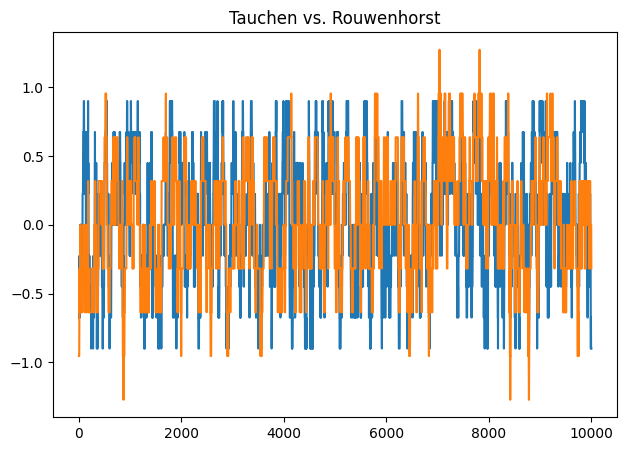

In [17]:
# Monte Carlo simulations to compare performance
# seed random number generator
seed(12345)

LEN_HIST = 10000

histories_tauchen_st = np.zeros((LEN_HIST), np.int8)
histories_tauchen_z = np.zeros((LEN_HIST))
histories_tauchen_st[0] = 1
histories_tauchen_z[0] = zgrid_tauchen[histories_tauchen_st[0]]

histories_rouwen_st = np.zeros((LEN_HIST), np.int8)
histories_rouwen_z = np.zeros((LEN_HIST))
histories_rouwen_st[0] = 1
histories_rouwen_z[0] = zgrid_rouwen[histories_rouwen_st[0]]

randarray = rand(LEN_HIST)

for j in range(1, LEN_HIST):
    for r in range(0, N_GRID):
        if randarray[j] < np.cumsum(P_tauchen[histories_tauchen_st[j - 1], :])[r]:
            histories_tauchen_z[j] = zgrid_tauchen[r]
            histories_tauchen_st[j] = r
            break
    for r in range(0, N_GRID):
        if randarray[j] < np.cumsum(P_rouwen[histories_rouwen_st[j - 1], :])[r]:
            histories_rouwen_z[j] = zgrid_rouwen[r]
            histories_rouwen_st[j] = r
            break

plt.subplot(1, 2, 1)
plt.plot(histories_tauchen_z[:])
plt.plot(histories_rouwen_z[:])
plt.title("Tauchen vs. Rouwenhorst")

fig = plt.gcf()
fig.set_size_inches(16, 5)
plt.show()

Finally, we want to measure the performance of the simulations. In other words, we are going to compute the mean, variance, and autocorrelation coefficient of both series and compare them with the real ones. Notice that we add a burn-in period (`T_EXCLUDE`), meaning an extra piece that we add at the start of the time series while simulating but throw away later. When you simulate a time series, the first part you simulate will not follow your chosen model and must be discarded.

In [18]:
# Compute mean, variance, and autocorrelation coefficient of both series
# Exclude the initial periods (Burn-in)
T_EXCLUDE = 100
tauchen_mean = np.mean(histories_tauchen_z[T_EXCLUDE:LEN_HIST])
rouwen_mean = np.mean(histories_rouwen_z[T_EXCLUDE:LEN_HIST])

print("Real mean:", 0, "Tauchen mean:", tauchen_mean, "Rouwen mean:", rouwen_mean)

tauchen_sd = np.std(histories_tauchen_z[T_EXCLUDE:LEN_HIST])
rouwen_sd = np.std(histories_rouwen_z[T_EXCLUDE:LEN_HIST])

print(
    "Real sd:",
    SIGMA / (1 - RHO**2) ** 0.5,
    "Tauchen sd:",
    tauchen_sd,
    "Rouwen_sd:",
    rouwen_sd,
)

tauchen_cov = np.cov(
    histories_tauchen_z[T_EXCLUDE : LEN_HIST - 1],  # noQA E203
    histories_tauchen_z[T_EXCLUDE + 1 : LEN_HIST],  # noQA E203
)
rouwen_cov = np.cov(
    histories_rouwen_z[T_EXCLUDE : LEN_HIST - 1],  # noQA E203
    histories_rouwen_z[T_EXCLUDE + 1 : LEN_HIST],  # noQA E203
)

tauchen_rho = tauchen_cov[0, 1] / tauchen_cov[0, 0]
rouwen_rho = rouwen_cov[0, 1] / rouwen_cov[0, 0]

print("Real rho:", RHO, "Tauchen rho:", tauchen_rho, "Rouwen rho:", rouwen_rho)

Real mean: 0 Tauchen mean: 0.036139187120654066 Rouwen mean: 0.04062967301810595
Real sd: 0.45003516037040936 Tauchen sd: 0.44027305149222923 Rouwen_sd: 0.4233634186236244
Real rho: 0.975 Tauchen rho: 0.966294593991392 Rouwen rho: 0.9728902087196065


Of course, we can improve the results by using more simulations, playing with the "grid size" in both methods and/or with "LAMBDA" in Tauchen's method.

The above algorithms are already available, for instance, in the following Python library: https://quanteconpy.readthedocs.io/en/latest/markov/approximation.html#



## **4. Conclusion**

In this lesson, we have worked through the concept of the Markov Chain and its application to a simple bond valuation case study. In addition, we have introduced the gambler's ruin problem and the Tauchen and Rouwenhorst discretization methods. In the next lesson, we will start with the Hidden Markov Model. 

See you there!

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
